In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ufl.algebra import Abs
from ufl import min_value, max_value, sign

from dolfin import *

plt.rcParams.update({'font.size': 18})
plt.rc('text', usetex = True)
plt.rc('font', **{'family' : "sans-serif"})
plt.rcParams.update({'text.latex.preamble' : [r'\usepackage{siunitx}', r'\usepackage{amsmath}']})

In [2]:
class DG0_problem():
    # A base class for DG0 problems
    def __init__(self, mesh, boundary_markers):
        self.V = FunctionSpace(mesh, 'DG', 0)
        self.boundary_markers = boundary_markers
        
        self.ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)
        self.dS = Measure('dS', domain=mesh, subdomain_data=boundary_markers)
        
        x_ = interpolate(Expression('x[0]', degree=1), self.V)
        self.delta_h = sqrt(jump(x_)**2)
        self.n = FacetNormal(mesh)
        
        self.cell_volume = CellVolume(mesh)
        self.min_cell_volume = min(project(self.cell_volume, self.V).vector()[:])
        
class CG1_problem():
    # A base class for CG1 problems
    def __init__(self, mesh, boundary_markers):
        self.V = FunctionSpace(mesh, 'CG', 1)
        self.boundary_markers = boundary_markers
        
        self.ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)
        self.dS = Measure('dS', domain=mesh, subdomain_data=boundary_markers)
        
        self.V_DG = FunctionSpace(mesh, 'DG', 0)
        cell_volume = CellVolume(mesh)
        self.min_cell_volume = min(project(cell_volume, self.V_DG).vector()[:])

In [3]:
class transient_advection_R11(CG1_problem):
    def __init__(self, mesh, boundary_markers):
        super().__init__(mesh, boundary_markers)
        
    def set_boundary_conditions(self, left_bc):
        self.bc_list = [DirichletBC(self.V, Constant(left_bc), self.boundary_markers, 2)]
        
    def set_problem(self, init_cond, s=0.0, adv_val=1.0, dt_val=1.0, theta_val=0.5):
        u = TrialFunction(self.V)
        w = TestFunction(self.V)
        
        self.u0 = project(init_cond, self.V)
        self.u1 = Function(self.V)
        self.adv = Constant(adv_val)
        self.dt = Constant(dt_val)
        theta = Constant(theta_val)
        one = Constant(1.0)
        
        def L(w, u):
            return w*self.adv*u.dx(0)
            
        delta_u = u - self.u0
        W = 0.5
        ww = (w*s-L(w, self.u0))

        a = ( w*u/self.dt + theta*L(w, u) )*dx
        L = ( w*self.u0/self.dt + w*s - (one-theta)*L(w, self.u0) )*dx
        
        problem = LinearVariationalProblem(a, L, self.u1, bcs=self.bc_list)
        self.solver = LinearVariationalSolver(problem)
        
    def get_CFL(self):
        return max(self.adv.values())*self.dt.values()[0]/self.min_cell_volume
        
    def solve(self, steps):
        u_list = [self.u0.copy()]
        
        for i in range(steps):
            self.solver.solve()
            self.u0.assign(self.u1)
            u_list.append(self.u0.copy())
            
        return u_list, self.V.tabulate_dof_coordinates().T[0]

In [4]:
class transient_advection_explicit_upwind(DG0_problem):
    def __init__(self, mesh, boundary_markers):
        super().__init__(mesh, boundary_markers)
        self.bc_list = []
        
        self.u0 = Function(self.V)
        self.u1 = Function(self.V)
        self.adv = Constant(1.0)
        self.dt = Constant(1.0)
        
        self.adv_vec = as_vector([self.adv])
        self.adv_np = ( dot ( self.adv_vec, self.n ) + Abs ( dot ( self.adv_vec, self.n ) ) ) / 2.0
        self.adv_nm = ( dot ( self.adv_vec, self.n ) - Abs ( dot ( self.adv_vec, self.n ) ) ) / 2.0

    def set_problem(self, init_cond, adv_val=1.0, dt_val=1.0):
        u = TrialFunction(self.V)
        w = TestFunction(self.V)
        one = Constant(1.0)
        
        self.u0.assign(project(init_cond, self.V))
        self.adv.assign(adv_val)
        self.dt.assign(dt_val)
        
        F = w*(u - self.u0)/self.dt*dx + jump(w)*jump(self.adv_np*self.u0)*self.dS \
            - w*self.adv*one*self.ds(2) + w*self.adv*self.u0*self.ds(3)
        
        a, L = lhs(F), rhs(F)
        
        problem = LinearVariationalProblem(a, L, self.u1, bcs=self.bc_list)
        self.solver = LinearVariationalSolver(problem)
        
    def get_CFL(self):
        return max(self.adv.values())*self.dt.values()[0]/self.min_cell_volume

    def solve(self, steps):
        u_list = [self.u0.copy()]
        
        for i in range(steps):
            self.solver.solve()
            self.u0.assign(self.u1)
            u_list.append(self.u0.copy())
            
        return u_list, self.V.tabulate_dof_coordinates().T[0]

In [5]:
class transient_advection_MacCormack(transient_advection_explicit_upwind):
    def __init__(self, mesh, boundary_markers):
        super().__init__(mesh, boundary_markers)
        self.up = Function(self.V)
        
    def set_problem(self, init_cond, adv_val=1.0, dt_val=1.0):
        u = TrialFunction(self.V)
        w = TestFunction(self.V)
        one = Constant(1.0)
        
        self.u0.assign(project(init_cond, self.V))
        self.adv.assign(adv_val)
        self.dt.assign(dt_val)
        
        F = w*(u - self.u0)/self.dt*dx \
            + jump(w)*jump(self.adv_np*self.u0)*self.dS \
            - w*self.adv*one*self.ds(2) + w*self.adv*self.u0*self.ds(3)
        a_predictor, L_predictor = lhs(F), rhs(F)
        
        problem = LinearVariationalProblem(a_predictor, L_predictor, self.up, bcs=self.bc_list)
        self.predictor = LinearVariationalSolver(problem)
        
        F = w*(Constant(2)*u - self.u0 - self.up)/self.dt*dx \
            + jump(w)*jump(self.adv_nm*self.up)*self.dS \
            - w*self.adv*one*self.ds(2) + w*self.adv*u*self.ds(3)
        a_corrector, L_corrector = lhs(F), rhs(F)
        
        problem = LinearVariationalProblem(a_corrector, L_corrector, self.u1, bcs=self.bc_list)
        self.corrector = LinearVariationalSolver(problem)
        
    def solve(self, steps):
        u_list = [self.u0.copy()]
        
        for i in range(steps):
            self.predictor.solve()
            self.corrector.solve()
            
            self.u0.assign(self.u1)
            u_list.append(self.u0.copy())
        
        return u_list, self.V.tabulate_dof_coordinates().T[0]

In [6]:
class transient_advection_SOU_flux_limiter(transient_advection_explicit_upwind):
    def __init__(self, mesh, boundary_markers):
        super().__init__(mesh, boundary_markers)
        self.up = Function(self.V)
        self.u_up = Function(self.V)
        self.u_down = Function(self.V)
        self.u_temp = Function(self.V)
        self.phi = Function(self.V)
        self.r = (self.u_down-self.up)/(self.up-self.u_up)
        
    
    def set_problem(self, init_cond, adv_val=1.0, dt_val=1.0):
        u = TrialFunction(self.V)
        w = TestFunction(self.V)
        one = Constant(1.0)
        
        self.u0.assign(project(init_cond, self.V))
        self.adv.assign(adv_val)
        self.dt.assign(dt_val)
        
        n_p = sign(( dot ( self.adv_vec, self.n ) + Abs ( dot ( self.adv_vec, self.n ) ) ) / 2.0)
        n_m = sign(( dot ( self.adv_vec, self.n ) - Abs ( dot ( self.adv_vec, self.n ) ) ) / 2.0)
        
        a_up = w*u/self.cell_volume*dx 
        L_up = jump(n_m*w)*jump(n_p*self.u_temp)*self.dS - w*one*self.ds(2)
        L_down = jump(n_p*w)*jump(n_m*self.u_temp)*self.dS
        
        problem = LinearVariationalProblem(a_up, L_up, self.u_up, bcs=self.bc_list)
        self.upwind_operator = LinearVariationalSolver(problem)
        
        problem = LinearVariationalProblem(a_up, L_down, self.u_down, bcs=self.bc_list)
        self.downwind_operator = LinearVariationalSolver(problem)
        
        # The midpoint method. First, forward half step.
        F = w*(u - self.u0)/(Constant(0.5)*self.dt)*dx \
            + jump(w)*jump(self.adv_np*self.u0)*self.dS \
            - w*self.adv*one*self.ds(2) + w*self.adv*self.u0*self.ds(3)

        a_predictor, L_predictor = lhs(F), rhs(F)
        
        problem = LinearVariationalProblem(a_predictor, L_predictor, self.up, bcs=self.bc_list)
        self.predictor = LinearVariationalSolver(problem)
        

        # Then use the half-stepped information to forward full step.
        F = w*(u - self.u0)/self.dt*dx\
            + jump(w)*(jump(self.adv_np*self.up) \
                       + Constant(0.5)*jump(n_p*self.phi) \
                       *(jump(self.adv_np*self.up) - jump(self.adv_np*self.u_up)))*self.dS \
            - w*self.adv*one*self.ds(2) + w*self.adv*self.up*self.ds(3)
        a_corrector, L_corrector = lhs(F), rhs(F)
        
        problem = LinearVariationalProblem(a_corrector, L_corrector, self.u1, bcs=self.bc_list)
        self.corrector = LinearVariationalSolver(problem)
        
    def solve(self, steps):
        u_list = [self.u0.copy()]
        
        for i in range(steps):
            self.predictor.solve()
            
            self.u_temp.assign(self.up)
            self.upwind_operator.solve()
            self.downwind_operator.solve()
            
            # superbee limiter
            #phi_val = project(max_value(0.0, max_value(min_value(self.r, 2.0), min_value(2.0*self.r, 1.0))), self.V)
            
            # Osher limiter, minmod limiter: beta=1.0
            beta = 1.5
            phi_val = project(max_value(0.0, min_value(self.r, beta)), self.V)
            self.phi.assign(phi_val)
            
            self.corrector.solve()
            
            self.u0.assign(self.u1)
            u_list.append(self.u0.copy())
        
        return u_list, self.V.tabulate_dof_coordinates().T[0]
        

In [7]:
def transient_adv_1d_DG_R22(nx, s, init_cond, dt_num, steps):
    # Input
    # mu:     diffusivity, constant
    # order:  element order. 1 = linear elements. 2 = quadratic elements.
    # nx:     number of elements
    
    # Output
    # u:      the solution, dolfin function
    
    mesh_1d = IntervalMesh(nx, 0, 1)
    
    h = 1.0/nx
    
    boundary_markers = MeshFunction('size_t', mesh_1d, dim=0)
    
    P1 = FiniteElement("DG", mesh_1d.ufl_cell(), 0)
    TH = MixedElement([P1, P1])
    V = FunctionSpace(mesh_1d, TH)
    V0 = V.sub(0).collapse()
    u = TrialFunction(V)
    w = TestFunction(V)
    
    u0 = project(init_cond, V0)
    
    DG_space = FunctionSpace(mesh_1d, 'DG', 0)
    
    adv = 2.0
    
    n = FacetNormal(mesh_1d)
    
    u_list = [u0.copy()]

    class left(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], 0.0, DOLFIN_EPS)

    class right(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], 1.0, DOLFIN_EPS)

    b_left = left()
    b_right = right()
        
    boundary_markers.set_all(0)
    
    b_left.mark(boundary_markers, 2)
    b_right.mark(boundary_markers, 3)
    
    ds = Measure('ds', domain=mesh_1d, subdomain_data=boundary_markers)
    dS = Measure('dS', domain=mesh_1d, subdomain_data=boundary_markers)

    bc = []
    
    dt = Constant(dt_num)
    one = Constant(1.0)
    
    adv_vec = as_vector([adv])
    adv_np = ( dot ( adv_vec, n ) + Abs ( dot ( adv_vec, n ) ) ) / 2.0
    adv_nm = ( dot ( adv_vec, n ) - Abs ( dot ( adv_vec, n ) ) ) / 2.0
    
    def L(w, u):
        return jump(w)*(0.5*jump(adv_np*u) + 0.5*jump(adv_nm*u))
        #return jump(w)*adv*avg(u)
        
    
    delta_u = as_vector([(u[0] - u0), (u[1] - u[0])])
    W = as_matrix([[7.0/24, -1.0/24], [13.0/24, 5.0/24]])
    W_inv = inv(W)
    WU = W*delta_u
    
    LL = as_vector([L(w[0], u[0] - u0), L(w[1], u[1] - u[0])])
    ww = as_vector([0.5, 0.5])
    
    
    F = dot( delta_u/dt, as_vector([w[0], w[1]]) )*dx\
        + (L(w[0], WU[0]) + L(w[1], WU[1]))*dS(0) \
        + 0.5*(L(w[0], u0) + L(w[1], u0))*dS(0) \
        + (0.5*(w[0]*Constant(adv)*u0) + 0.5*(w[1]*Constant(adv)*u0))*ds(3) \
        - (0.5*(w[0]*Constant(adv)*one) + 0.5*(w[1]*Constant(adv)*one))*ds(2) \
        
    a, L = lhs(F), rhs(F)

    u = Function(V)
    
    problem = LinearVariationalProblem(a, L, u, bcs=bc)
    solver = LinearVariationalSolver(problem)
    
    prm = solver.parameters
    
    prm['krylov_solver']['absolute_tolerance'] = 1e-12
    prm['krylov_solver']['relative_tolerance'] = 1e-10
    prm['krylov_solver']['maximum_iterations'] = 1000
    #if iterative_solver:
    prm['linear_solver'] = 'gmres'
    prm['preconditioner'] = 'ilu'
    
    CFL = adv*dt_num/h
    print('Courant number = ', CFL)
    
    for i in range(steps):
        solver.solve()
        
        u1, u2 = u.split(True)
        u0.assign(u2)
        u_list.append(u0.copy())

    return u_list, V0.dofmap().dofs(), V0.tabulate_dof_coordinates().T[0]

In [8]:
# Define 1D mesh
nx = 50
xmin = 0.0
xmax = 1.0
mesh_1d = IntervalMesh(nx, xmin, xmax)

In [9]:
# Define boundary markers
boundary_markers = MeshFunction('size_t', mesh_1d, dim=0)

class left(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0, DOLFIN_EPS)

class right(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 1.0, DOLFIN_EPS)

b_left = left()
b_right = right()

boundary_markers.set_all(0)

b_left.mark(boundary_markers, 2)
b_right.mark(boundary_markers, 3)

In [10]:
# Define source terms, boundary conditions, and initial conditions
source = Constant(0.0)
left_bc = 1.0
init_cond = Expression('x[0]<=0.2 ? 1.0 : 0.0', degree=0)

In [11]:
problem = transient_advection_R11(mesh_1d, boundary_markers)
problem.set_boundary_conditions(left_bc)
problem.set_problem(init_cond, s=source, adv_val=1.0, dt_val=3.0/200)
CFL1 = problem.get_CFL()
u1, coord1 = problem.solve(steps=40)

# u4, dof, coord4 = transient_adv_1d_DG_SOU(50, source, init_cond, dt_num=2.0/200, steps=30)
# u5, dof, coord5 = transient_adv_1d_DG_two_steps(50, source, init_cond, dt_num=1.5/200, steps=40)

#u6, dof, coord6 = transient_adv_1d_DG_two_steps_TVD(50, source, init_cond, dt_num=0.75/200, steps=80)
#u4, dof, coord4 = transient_adv_1d_DG_ENO(50, source, init_cond, dt_num=1.5/200, steps=1)

In [12]:
problem = transient_advection_explicit_upwind(mesh_1d, boundary_markers)
problem.set_problem(init_cond, adv_val=2.0, dt_val=1.5/200)
CFL2 = problem.get_CFL()
u2, coord2 = problem.solve(steps=40)

In [13]:
u3, dof, coord3 = transient_adv_1d_DG_R22(50, source, init_cond, dt_num=6.0/200, steps=10)

Courant number =  3.0


In [14]:
problem = transient_advection_SOU_flux_limiter(mesh_1d, boundary_markers)
problem.set_problem(init_cond, adv_val=2.0, dt_val=1.5/200)
CFL4 = problem.get_CFL()
u4, coord4 = problem.solve(steps=40)

In [15]:
problem = transient_advection_MacCormack(mesh_1d, boundary_markers)
problem.set_problem(init_cond, adv_val=2.0, dt_val=1.5/200)
CFL5 = problem.get_CFL()
u5, coord5 = problem.solve(steps=40)

In [16]:
x_space = np.linspace(0,1,51)
sol_u = np.zeros_like(x_space)
sol_u[x_space<0.8] = 1.0

x_space_DG = (x_space[:-1] + x_space[1:])/2
sol_u_DG = np.zeros_like(x_space_DG)
sol_u_DG[x_space_DG<0.8] = 1.0

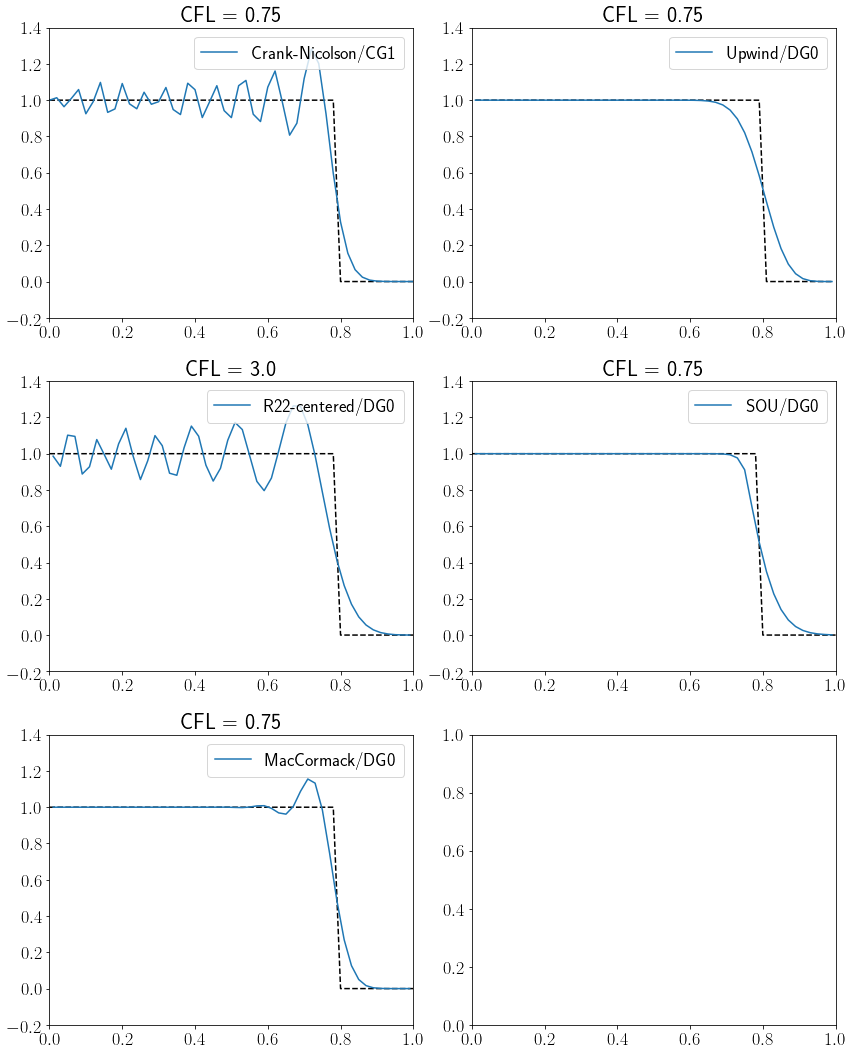

In [17]:
# Fig. 3.19 Propagation of a steep front using Galerkin and the Crank-Nicolson scheme
fig, ax = plt.subplots(3, 2, figsize=(12,15))
ax[0,0].plot(x_space, sol_u, c='k', ls='--')#, label='initial condition')
ax[0,0].plot(coord1, u1[-1].vector()[:], c='C0', label='Crank-Nicolson/CG1')

ax[0,0].set_ylim(-0.2, 1.4)
ax[0,0].set_xlim(0, 1.0)
ax[0,0].legend(loc='upper right')
ax[0,0].set_title('CFL = ' + str(np.round(CFL1, 3)))

ax[0,1].plot(x_space_DG, sol_u_DG, c='k', ls='--')
ax[0,1].plot(coord2, u2[-1].vector()[:], c='C0', label='Upwind/DG0')

ax[0,1].set_ylim(-0.2, 1.4)
ax[0,1].set_xlim(0, 1.0)
ax[0,1].legend(loc='upper right')
ax[0,1].set_title('CFL = ' + str(np.round(CFL2, 3)))

ax[1,0].plot(x_space, sol_u, c='k', ls='--')
ax[1,0].plot(coord3, u3[-1].vector()[:], c='C0', label='R22-centered/DG0')
ax[1,0].legend(loc='upper right')

ax[1,0].set_ylim(-0.2, 1.4)
ax[1,0].set_xlim(0, 1.0)
ax[1,0].set_title('CFL = 3.0')

ax[1,1].plot(x_space, sol_u, c='k', ls='--')
ax[1,1].plot(coord4, u4[-1].vector()[:], c='C0', label='SOU/DG0')
ax[1,1].legend(loc='upper right')

ax[1,1].set_title('CFL = ' + str(np.round(CFL4, 3)))
ax[1,1].set_ylim(-0.2, 1.4)
ax[1,1].set_xlim(0, 1.0)

ax[2,0].plot(x_space, sol_u, c='k', ls='--')
ax[2,0].plot(coord5, u5[-1].vector()[:], c='C0', label='MacCormack/DG0')
ax[2,0].legend(loc='upper right')

ax[2,0].set_ylim(-0.2, 1.4)
ax[2,0].set_xlim(0, 1.0)
ax[2,0].set_title('CFL = ' + str(np.round(CFL5, 3)))

plt.tight_layout()
plt.show()